# Stim and LFP power
## Does optogenetic (laser) stimulation do anything to broad-band or theta-band LFP power?

### Needs emk_neuro_analysis environment
### load LFP, DIO and time data

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import itertools
from scipy.signal import sosfiltfilt, butter, hilbert

from emk_analysis import builder_experiment as bld_exp
from emk_neuro_analysis.lfp import iterator as lfp_iter
from emk_neuro_analysis.position import iterator as pos_iter
from mountainlab_pytools import mdaio
from emk_analysis import iterator as emk_iter

from scipy import signal, stats
from pathlib import Path
from rec_to_binaries.read_binaries import readTrodesExtractedDataFile

### Experiment parameters

In [21]:
# name of experiment
experiment_name = 'O3'

experiment_phase = 'stim'

# data drive
data_disk = 'nvme0'

# directory with the preprocessed/extracted data files
dir_preprocess = f'/media/{data_disk}/Data/{experiment_name}/preprocessing/'

# Figure folder, where you want to save the output figures. Usually in your experiment folder for analysis.
dir_fig = f'/media/{data_disk}/Analysis/{experiment_name}/Results/'

# Location of track config file. 
# This is an excel spreadsheet that specifies the identities of the DIO for your experiment.
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/CLC_linear_Config.xlsx')

# Location of day records. 
# This is an excel spreadsheet that lists details for each session on your experiment day.
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')

# chose the date - as a list
choose_dates = [ '20220512',]

# choose the epoch - as a list
epoch_list = [1, 2, 3, 4]

# choose the tetrodes - as a list
tet_list = [28, 27, 20, 19, 17, 16, 15, ]

### Import DIO data

In [22]:
# Load DIO
%matplotlib notebook

plot_DIO = False

filter_retrigger = 0

# Track config
fname_config_track = (f'/media/{data_disk}/Data/{experiment_name}/config/Maze_S_Config.xlsx')

# Day records
dir_records = (f'/media/{data_disk}/Data/{experiment_name}/dayrecords/')
data_days = []

for curr_date in choose_dates:
    fname_day_record = f'{dir_records}{curr_date}_stim_training_record.xlsx'
    dict_sessions_day = bld_exp.build_day_from_file(experiment_name,
                                track_config_file=fname_config_track,
                                day_record_file=fname_day_record)
    data_days.append(dict_sessions_day)

# build session records
dict_sessions_all = bld_exp.build_all_sessions(data_days)

# time plotting settings
tick_minutes = mdates.MinuteLocator(interval=5)
tick_minutes_fmt = mdates.DateFormatter('%H:%M')
tick_minor = mdates.SecondLocator(interval=10)

# Specify parameters
dict_sensor_pump_map = {1: {'sensor': 'entrance_sensor'},
                        2: {'pump': 'stim_pump'},
                        6: {'sensor': 'Entrance_sensor'},
                        7: {'sensor': 'Exit_sensor'},
                        9: {'pump': 'reward 1 pump'},
                        }

# list dio to extract
list_dio = [2, 9]
y_label = ['laser on',
           'reward 1 off',
          ]

# plot each session
# get data for each animal
# initiate output
dict_dio_out = {}
for animal_id in ['O3', ]:
    
    print(animal_id)
    cls_behavior = emk_iter.ProcessBehavior(dict_sessions_all,
                                        experiment_name, trodes_version=2)
    cls_behavior.filter_animals(animal_id)
    dict_rewards = cls_behavior.count_reward_delivered()
    
    if not dict_rewards:
        continue
        
    df_pump = cls_behavior.report_reward_delivered(remove_zeroth=False,
                                               output_raw=False,
                                               filter_retrigger=None)
    df_sensor = cls_behavior.report_triggers(remove_zeroth=False,
                                         output_raw=False,
                                         filter_retrigger=filter_retrigger)
    
    # get unique sessions
    sessions_unique = np.sort(df_sensor['session'].unique())
    print(sessions_unique)
    n_subplots = len(sessions_unique)
    
    if plot_DIO:
        fig = plt.figure(figsize=(10, n_subplots*3+2))
        axs = fig.subplots(n_subplots, 1)
        if n_subplots == 1:
            axs = [axs, ]
            sessions_unique = [sessions_unique[0], ]
            
    else:
        axs = [0]*len(sessions_unique)
        
    for sn, (ax, session) in enumerate(zip(axs, sessions_unique)):
        # get session times
        curr_start = dict_sessions_all.get(session).get('start')
        curr_end = dict_sessions_all.get(session).get('end')
        # get sensor and pump times
        df_sensor_curr = df_sensor[df_sensor['session']==session]
        df_sensor_curr = df_sensor_curr[(df_sensor_curr['on_time_sys']>=curr_start)
                                       & (df_sensor_curr['on_time_sys']<curr_end)]
        df_pump_curr = df_pump[df_pump['session']==session]
        df_pump_curr = df_pump_curr[(df_pump_curr['on_time_sys']>=curr_start)
                                       & (df_pump_curr['on_time_sys']<curr_end)]
        dict_dio_out.update({int(session.split('_')[1]): df_pump_curr})
        
        if not plot_DIO:
            continue
        
        for i, d in enumerate(list_dio):
            #print(d)
            yval = i+1
            curr_pump_name = dict_sensor_pump_map.get(d).get('pump')
            df_plot_pump = df_pump_curr[df_pump_curr['dio']==curr_pump_name]
            curr_sensor_name = dict_sensor_pump_map.get(d).get('sensor')
            df_plot_sensor = df_sensor_curr[df_sensor_curr['dio']==curr_sensor_name]
            # plot well triggers
            
            for ind, row in df_plot_sensor.iterrows():
                ax.scatter(row['on_time_sys'], yval+.3, s=25, c='k')
                
            for ind, row in df_plot_pump.iterrows():
                
                try:
                    ax.plot([row['on_time_sys'],
                              row['off_time_sys']], [yval+.15, yval+.15], c='r')
                
                except:
                    pass

O3
/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_01_stim.DIO/20220512_O3_01_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_02_stim.DIO/20220512_O3_02_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.DIO/20220512_O3_03_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_04_stim.DIO/20220512_O3_04_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: F

/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_01_stim.DIO/20220512_O3_01_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time


/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_02_stim.DIO/20220512_O3_02_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time


/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.DIO/20220512_O3_03_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time


/media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_04_stim.DIO/20220512_O3_04_stim.dio_ECU_Dout1.dat data failed to load
no dataframe created - data not suitable
no dataframe created - data not suitable
no dataframe created - data not suitable


/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/emk_analysis/extractor_dio.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_off['time_sys_diff'] = df_off['time_sys'] - curr_time
/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (

no dataframe created - data not suitable
no dataframe created - data not suitable
['20220512_01' '20220512_02' '20220512_03' '20220512_04']


### Import LFP data

In [23]:
lfp_data, lfp_timestamp, _ = lfp_iter.iterate_lfp_load(dir_preprocess, 
                                                       tet_list,
                                                       choose_dates, 
                                                       epoch_list=epoch_list, 
                                                       remove_movement_artifact=False,
                                                       filter_linenoise=True,
                                                       print_debug=False)

/home/jaiyu/.conda/envs/emk_neuro_analysis/lib/python3.6/site-packages/rec_to_binaries/read_binaries.py:73: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 28
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 27
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 20
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 19
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 17
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 16
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_03_stim.LFP tet 15
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_02_stim.LFP tet 28
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_02_stim.LFP tet 27
filter 60Hz noise
Loaded /media/nvme0/Data/O3/preprocessing/20220512/20220512_O3_02_stim.LFP tet 20
filter 60Hz noise


### LFP traces all sessions all tetrodes

<IPython.core.display.Javascript object>


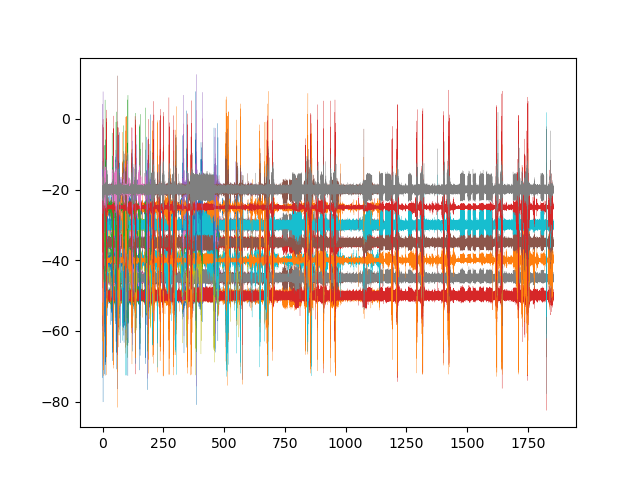

In [24]:
%matplotlib notebook

fs = 30000

for i, (k, v) in enumerate(lfp_data.items()):
    for e in epoch_list:
        plt.plot((np.array(lfp_timestamp.get(e))-np.array(lfp_timestamp.get(e))[0])/fs, 
                  np.array(v.get(e))/1000+5*(i-10), lw=.15)

In [25]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    """
    Return a dictionary of filtered lfp data

    :param filter_name: name of the filter you want to use
    :type filter_name: string
    :param flattened_array: array of the raw lfp data
    :type flattened_array: np array
    :param sampling_freq: frequency lfp data was sampled at
    :type sampling_freq: int
    :param order: order of filter
    :type order: int
    :param lowcut: lower border of frequencies allowed to pass
    :type lowcut: int
    :param highcut: upper border of frequencies allowed to 
    :type highcut: int
    
    :return: filtered lfp data
    :rtype: np array
    """
    if filter_name == 'elliptical': 
        sos = signal.ellip(order, 0.01, 120, [lowcut,highcut], btype = 'bp', output = 'sos', fs = sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut,highcut], 'bp', fs = sampling_freq, output='sos')
    if filter_name =='cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    
    y = signal.sosfiltfilt(sos, flattened_array)
    
    return y

In [26]:
# get laser_on timestamp dictionary
stim_timestamp = {}
for k in dict_dio_out:
    stim_timestamp[k] = np.array(dict_dio_out[k].get('on_time'))

### visualize LFP and stim

In [65]:
reward_1_timestamp = np.array(df_sensor.get('off_time'))

In [68]:
df_sensor

,on_time_sys,on_time,on_state,off_time_sys,off_time,off_state,duration,dio,session,dio_bit
0,2022-05-12 14:01:09.448833,3391098,1,2022-05-12 14:01:10.195233,3413490,0,0 days 00:00:00.746400,trigger_sensor,20220512_01,ECU_Din7
1,2022-05-12 14:01:10.213767,3414046,1,2022-05-12 14:01:10.346767,3418036,0,0 days 00:00:00.133000,trigger_sensor,20220512_01,ECU_Din7
2,2022-05-12 14:01:10.360300,3418442,1,2022-05-12 14:01:10.486633,3422232,0,0 days 00:00:00.126333,trigger_sensor,20220512_01,ECU_Din7
3,2022-05-12 14:01:10.518734,3423195,1,2022-05-12 14:01:10.800767,3431656,0,0 days 00:00:00.282033,trigger_sensor,20220512_01,ECU_Din7
4,2022-05-12 14:01:10.825600,3432401,1,2022-05-12 14:01:11.107200,3440849,0,0 days 00:00:00.281600,trigger_sensor,20220512_01,ECU_Din7
...,...,...,...,...,...,...,...,...,...,...
550,2022-05-12 17:18:26.823467,64728413,1,2022-05-12 17:18:27.953900,64762326,0,0 days 00:00:01.130433,trigger_sensor,20220512_04,ECU_Din7
551,2022-05-12 17:18:27.968034,64762750,1,2022-05-12 17:18:33.785333,64937269,0,0 days 00:00:05.817299,trigger_sensor,20220512_04,ECU_Din7
552,2022-05-12 17:19:04.564200,65860635,1,2022-05-12 17:19:04.653567,65863316,0,0 days 00:00:00.089367,trigger_sensor,20220512_04,ECU_Din7
553,2022-05-12 17:19:05.122766,65877392,1,2022-05-12 17:19:05.261100,65881542,0,0 days 00:00:00.138334,trigger_sensor,20220512_04,ECU_Din7


### align to event onset, compare group_1 and group_2 signals in time window

In [27]:
win_size_time = 100 # in ms

win_size_timestamp = win_size_time*(10**(-3))*fs

stim_windows = {}

for k in stim_timestamp:
    
    curr_lfp_timestamp = np.array(lfp_timestamp[k])
    curr_win_start = np.array(stim_timestamp[k]) - win_size_timestamp
    curr_win_end = np.array(stim_timestamp[k]) + win_size_timestamp
    
    stim_windows[k] = [tuple([np.abs(curr_lfp_timestamp - start).argmin(), 
                              np.abs(curr_lfp_timestamp -end).argmin()])
                       for start, end in zip(curr_win_start, curr_win_end)]

In [60]:
# sessions
group_1_session = [1, ]
group_2_session = [3, 4]

# tetrodes
# tet_list = [28, 27, 20, 19, 17, 16, 15, ] 
# all tetrodes available
tet_include = [27, 28]

group_1_label = 'baseline'
group_2_label = 'laser'

In [61]:
filter_signal = False

band_highcut = 10
band_lowcut = 4

group_1_stacked = []
for tet in tet_include:
    
    for session in group_1_session:
        
        curr_lfp = lfp_data[tet][session]
        if filter_signal:
            curr_lfp = bandpass_filter('butterworth', curr_lfp, fs/20, 
                                       1, band_lowcut, band_highcut)
            
        for start, end in stim_windows[session]:
            group_1_stacked.append(curr_lfp[start:end])

group_1_avg = np.average(group_1_stacked, axis=0)
group_1_sem = stats.sem(group_1_stacked, axis=0)
group_1_std = stats.tstd(group_1_stacked, axis=0)

group_2_stacked = []
for tet in tet_include:
    
    for session in group_2_session:
        
        curr_lfp = lfp_data[tet][session]
        if filter_signal:
            curr_lfp = bandpass_filter('butterworth', curr_lfp, fs/20, 
                                       1, band_lowcut, band_highcut)
            
        for start, end in stim_windows[session]:
            group_2_stacked.append(curr_lfp[start:end])

group_2_avg = np.average(group_2_stacked, axis=0)
group_2_sem = stats.sem(group_2_stacked, axis=0)
group_2_std = stats.tstd(group_2_stacked, axis=0)

<IPython.core.display.Javascript object>


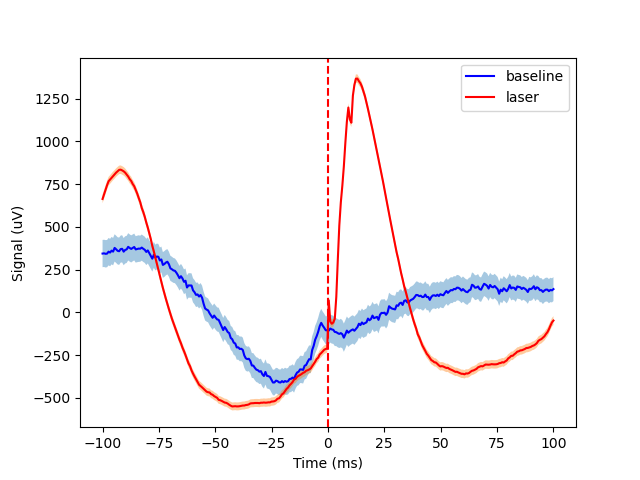

Text(0, 0.5, 'Signal (uV)')

In [62]:
%matplotlib notebook

plt.plot(np.linspace(-win_size_time, win_size_time, len(group_1_avg)), 
         group_1_avg, c='b', label=group_1_label)

plt.fill_between(np.linspace(-win_size_time, win_size_time, len(group_1_avg)),
                 group_1_avg + group_1_sem,
                 group_1_avg - group_1_sem,
                 alpha=0.4)

plt.plot(np.linspace(-win_size_time, win_size_time, len(group_2_avg)), 
         group_2_avg, c='r', label=group_2_label)

plt.fill_between(np.linspace(-win_size_time, win_size_time, len(group_2_avg)),
                 group_2_avg + group_2_sem,
                 group_2_avg - group_2_sem,
                 alpha=0.4)

plt.axvline(x=0, lw=1.5, ls='--', c='r')

plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('Signal (uV)')